In [1]:
#Notebook to make Figure 2 of the GRL paper, and Figure S2. 
#Combines stuff that was originally done in GregoryTRACMIP.ipynb and 
#AnalyzeGregoryFeedbacks.ipynb, into one paper.

#Rick Russotto
#Started 11-18-19
#12-11-19: adding instantaneous CO2 forcing
#2-2-20: adding Planck-Lapse Rate decomposition

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from voigtColors import voigtColors

In [3]:
#Model lists
models_12 = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL',
             'MetUM-GA6-ENT', 'NorESM2']

legend_12 = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL',
             'MetUM-GA6-ENT', 'NorESM2', 'Multi-model mean']

#For LW cloud stuff
models_10 = ['AM2', 'CAM3', 'CAM4', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 
             'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT']

#For LW water vapor, all models except CNRM which had zero water vapor at certain heights
models_noCNRM = ['AM2', 'CAM3', 'CAM4', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL',
             'MetUM-GA6-ENT', 'NorESM2']

#(means for other variables missing models are OK because it's at all latitudes, not just some)

In [4]:
#Load the effective forcing and net feedback
ds_total = xr.open_dataset('nc_from_xarray/GregoryTotalForcingFeedbackStorage_a4.nc')

In [5]:
#Load the APRP Gregory results
ds_APRP = xr.open_dataset('nc_from_xarray/GregoryAPRP_a4.nc')

In [6]:
#Load the LW radiative kernel results
ds_kernel_ta = xr.open_dataset('nc_from_xarray/Gregory_kernel_ta_a4.nc')
ds_kernel_wv = xr.open_dataset('nc_from_xarray/Gregory_kernel_wv_a4.nc')
ds_kernel_ts = xr.open_dataset('nc_from_xarray/Gregory_kernel_ts_a4.nc')

In [7]:
#Load the LW cloud results
ds_dLWCRE_raw = xr.open_dataset('nc_from_xarray/Gregory_dLWCRE_raw_a4.nc')
ds_dLWCRE_co = xr.open_dataset('nc_from_xarray/Gregory_dLWCRE_co_a4.nc')

In [8]:
#Caclculate the instantaneous radiative forcing by subtracting all the rapid adjustments
#from the effective forcing
f_inst = ds_total['forcing'] - (ds_APRP['adj_cloud'] + ds_APRP['adj_noncloud']
                                + ds_dLWCRE_co['adj'] - ds_kernel_wv['adj'] - ds_kernel_ta['adj'])

In [9]:
#Load the Planck and lapse rate feedback results
ds_kernel_lr = xr.open_dataset('nc_from_xarray/Gregory_kernel_lr_a4.nc')
ds_kernel_pl = xr.open_dataset('nc_from_xarray/Gregory_kernel_pl_a4.nc')

In [10]:
#print(f_inst)
#print(f_inst.isel(lat=20)) #OK, the subtraction gets rid of the extra models, matching up on dimensions. 
#print(ds_total['forcing'].isel(lat=20))

In [11]:
#Colors for the individual forcings/feedbacks, from the results scatter plot
#Wait--this is hard-coded anyway
colorsEachExp = {'all': 'k', 
                 'no_adj_sw_cloud': 'cornflowerblue', 
                 'no_adj_sw_noncloud': 'turquoise', #water vapor
                 'no_adj_lw_cloud': 'darkblue',
                 'no_adj_lw_wv': 'green',
                 'no_adj_lw_ta': 'red',
                 'no_adj_lw_lr': 'magenta', 
                 'no_adj_lw_pl': 'red', #I think this should be 0
                 'no_fb_sw_cloud': 'cornflowerblue',
                 'no_fb_sw_noncloud': 'turquoise',  #water vapor
                 'no_fb_lw_cloud': 'darkblue',
                 'no_fb_lw_wv': 'green',
                 'no_fb_lw_ts': 'coral',
                 'no_fb_lw_ta_05p': [0.4, 0, 0], 
                 'no_fb_lw_ta_10p': [0.6, 0.2, 0.2], 
                 'no_fb_lw_ta_15p': [0.8, 0.4, 0.4],
                 'no_fb_lw_lr': 'magenta', 
                 'no_fb_lw_pl': 'red'
                }

In [ ]:

#####   VERSION WITH TOTAL ATMOSPHERIC TEMPERATURE FEEDBACK   #####


In [44]:
#Legend text for the rapid adjustments and feedbacks
legend_adjustments = ['Inst. CO$_2$ forcing', 'SW cloud rapid adj.', 'SW water vapor rapid adj.', 
                      'LW cloud rapid adj.', 'LW water vapor rapid adj.', 'LW lapse rate rapid adj.']
legend_feedbacks = ['SW cloud', 'SW water vapor', 
                      'LW cloud', 'LW water vapor', 
                    'LW atmospheric temperature', 'LW surface temperature']

In [12]:
#Calculate multi-model means and measure of spread (range of models)
#Make sure missing model for water vapor isn't included (&c. for other effects)
#Skipped 2 edge latitudes because conversion of nans to 0s somewhere messed up these values for 
#some models/experiments. Verified that this did not affect EBM results to within 1 pixel of later plots. 

/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


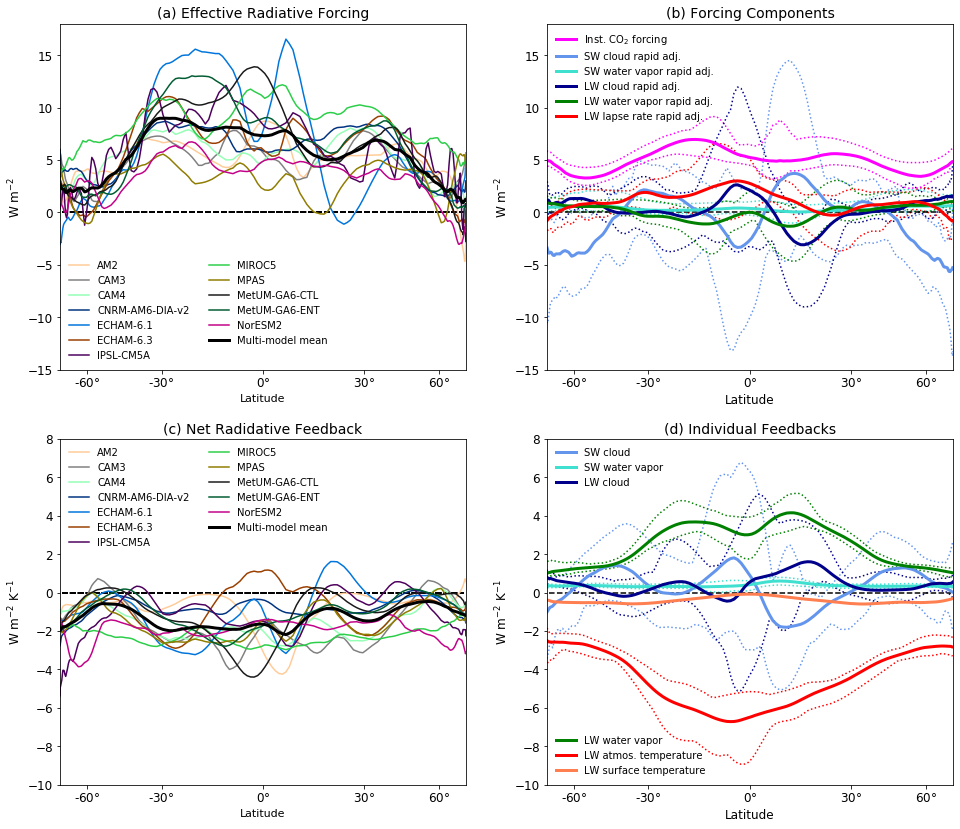

In [68]:
#Make the figure
plt.figure(figsize=(16,14))

#Effective Forcing
ax = plt.subplot(2,2,1)
for model in models_12:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['forcing'].sel(model=model), color=voigtColors[model])
    plt.hlines(0, -.99, .99, linestyles='dashed')
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['forcing'].mean(dim='model'), 'k', linewidth=3)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.xlabel('Latitude', fontsize=11)
plt.title('(a) Effective Radiative Forcing', fontsize=14)
ax.legend(legend_12, loc = 'lower left', frameon=False, ncol=2)
plt.axis([-1, 1, -15, 18])

#Net Feedback
ax = plt.subplot(2,2,3)
for model in models_12:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['feedback'].sel(model=model), color=voigtColors[model])
    plt.hlines(0, -.99, .99, linestyles='dashed')
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['feedback'].mean(dim='model'), 'k', linewidth=3)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$ K$^{-1}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.xlabel('Latitude', fontsize=11)
plt.title('(c) Net Radidative Feedback', fontsize=14)
ax.legend(legend_12, loc = 'upper left', frameon=False, ncol=2)
plt.axis([-1, 1, -10, 8])

#Individual Rapid Adjustments and feedbacks
lat = ds_total.lat
sinlat = np.sin(lat*np.pi/180.)

#Individual Rapid Adjustments
#Set up panel
ax = plt.subplot(2,2,2)
plt.hlines(0, -.99, .99, linestyles='dashed')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.title('(b) Forcing Components', fontsize=14)
#Means
plt.plot(sinlat[2:-2], f_inst.mean(dim='model')[2:-2], color='magenta', linewidth=3)
plt.plot(sinlat[2:-2], ds_APRP['adj_cloud'].mean(dim='model')[2:-2], 'cornflowerblue', linewidth=3)
plt.plot(sinlat[2:-2], ds_APRP['adj_noncloud'].mean(dim='model')[2:-2], 'turquoise', linewidth=3)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['adj'].mean(dim='model')[2:-2], 'darkblue', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_wv['adj'].sel(model=models_noCNRM).mean(dim='model')[2:-2], 'green', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_ta['adj'].mean(dim='model')[2:-2], 'red', linewidth=3)
#Spreads (just max, min to start)
plt.plot(sinlat[2:-2], f_inst.max(dim='model')[2:-2], color='magenta', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_cloud'].max(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_noncloud'].max(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['adj'].max(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['adj']).sel(model=models_noCNRM).max(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_ta['adj']).max(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#min
plt.plot(sinlat[2:-2], f_inst.min(dim='model')[2:-2], color='magenta', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_cloud'].min(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_noncloud'].min(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['adj'].min(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['adj']).sel(model=models_noCNRM).min(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_ta['adj']).min(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#finish panel stuff
ax.legend(legend_adjustments, loc = 'upper left', frameon=False)
plt.axis([-1, 1, -15, 18])


#Individual Feedbacks
#Set up panel
ax = plt.subplot(2,2,4)
plt.hlines(0, -.99, .99, linestyles='dashed')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$ K$^{-1}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.title('(d) Individual Feedbacks', fontsize=14)
#Means
l1, = ax.plot(sinlat[2:-2], ds_APRP['fb_cloud'].mean(dim='model')[2:-2], 'cornflowerblue', linewidth=3, label='SW cloud')
l2, = ax.plot(sinlat[2:-2], ds_APRP['fb_noncloud'].mean(dim='model')[2:-2], 'turquoise', linewidth=3, label='SW water vapor')
l3, = ax.plot(sinlat[2:-2], ds_dLWCRE_co['fb'].mean(dim='model')[2:-2], 'darkblue', linewidth=3, label='LW cloud')
l4, = ax.plot(sinlat[2:-2], -ds_kernel_wv['fb'].sel(model=models_noCNRM).mean(dim='model')[2:-2], 'green', linewidth=3, label='LW water vapor')
l5, = ax.plot(sinlat[2:-2], -ds_kernel_ta['fb'].mean(dim='model')[2:-2], 'red', linewidth=3, label='LW atmos. temperature')
l6, = ax.plot(sinlat[2:-2], -ds_kernel_ts['fb'].mean(dim='model')[2:-2], 'coral', linewidth=3, label='LW surface temperature')
#Spreads (just max, min to start--note the surface temperature kernel has no inter-model spread)
plt.plot(sinlat[2:-2], ds_APRP['fb_cloud'].max(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['fb_noncloud'].max(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['fb'].max(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['fb']).sel(model=models_noCNRM).max(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_ta['fb']).max(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#min
plt.plot(sinlat[2:-2], ds_APRP['fb_cloud'].min(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['fb_noncloud'].min(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['fb'].min(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['fb']).sel(model=models_noCNRM).min(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_ta['fb']).min(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#finish panel stuff--legend (split in two)
first_legend = ax.legend(handles=[l1, l2, l3], loc = 'upper left', frameon=False)
ax.add_artist(first_legend)
plt.legend(handles = [l4, l5, l6], loc = 'lower left', frameon=False)
plt.axis([-1, 1, -10, 8])


plt.savefig('plots/Figure2.png')
plt.savefig('plots/Figure2.pdf')

#plt.savefig('plots/Figure2_1000.png', dpi=1000)


In [ ]:

#####   VERSIONS WITH PLANCK/LAPSE RATE DECOMPOSITION   #####


In [19]:
#Legend text for the rapid adjustments and feedbacks
legend_adjustments = ['Inst. CO$_2$ forcing', 'SW cloud', 'SW water vapor', 'LW cloud', 'LW water vapor', 'LW lapse rate']


/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


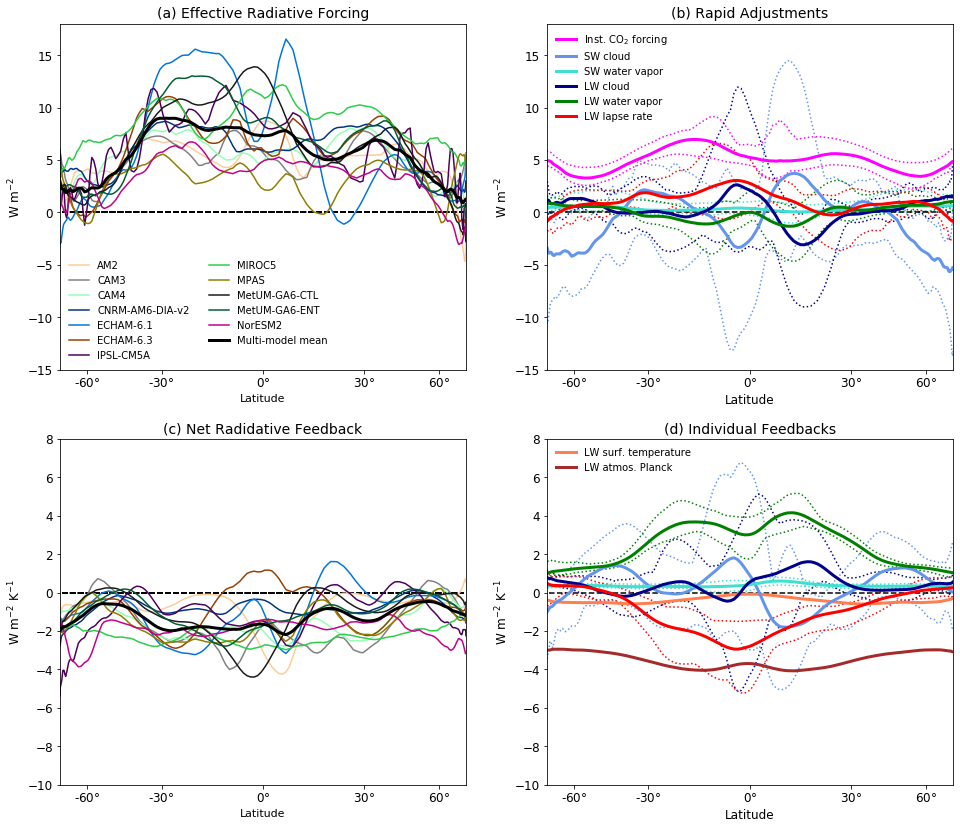

In [27]:
#Make the figure
plt.figure(figsize=(16,14))

#Effective Forcing
ax = plt.subplot(2,2,1)
for model in models_12:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['forcing'].sel(model=model), color=voigtColors[model])
    plt.hlines(0, -.99, .99, linestyles='dashed')
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['forcing'].mean(dim='model'), 'k', linewidth=3)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.xlabel('Latitude', fontsize=11)
plt.title('(a) Effective Radiative Forcing', fontsize=14)
ax.legend(legend_12, loc = 'lower left', frameon=False, ncol=2)
plt.axis([-1, 1, -15, 18])

#Net Feedback
ax = plt.subplot(2,2,3)
for model in models_12:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['feedback'].sel(model=model), color=voigtColors[model])
    plt.hlines(0, -.99, .99, linestyles='dashed')
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['feedback'].mean(dim='model'), 'k', linewidth=3)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$ K$^{-1}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.xlabel('Latitude', fontsize=11)
plt.title('(c) Net Radidative Feedback', fontsize=14)
plt.axis([-1, 1, -10, 8])

#Individual Rapid Adjustments and feedbacks
lat = ds_total.lat
sinlat = np.sin(lat*np.pi/180.)

#Individual Rapid Adjustments
#Set up panel
ax = plt.subplot(2,2,2)
plt.hlines(0, -.99, .99, linestyles='dashed')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.title('(b) Rapid Adjustments', fontsize=14)
#Means
plt.plot(sinlat[2:-2], f_inst.mean(dim='model')[2:-2], color='magenta', linewidth=3)
plt.plot(sinlat[2:-2], ds_APRP['adj_cloud'].mean(dim='model')[2:-2], 'cornflowerblue', linewidth=3)
plt.plot(sinlat[2:-2], ds_APRP['adj_noncloud'].mean(dim='model')[2:-2], 'turquoise', linewidth=3)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['adj'].mean(dim='model')[2:-2], 'darkblue', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_wv['adj'].sel(model=models_noCNRM).mean(dim='model')[2:-2], 'green', linewidth=3)
#plt.plot(sinlat, -ds_kernel_ta['adj'].mean(dim='model'), 'red', linewidth=3)
#plt.plot(sinlat, -ds_kernel_pl['adj'].mean(dim='model'), 'red', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_lr['adj'].mean(dim='model')[2:-2], 'red', linewidth=3)
#Spreads (just max, min to start)
plt.plot(sinlat[2:-2], f_inst.max(dim='model')[2:-2], color='magenta', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_cloud'].max(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_noncloud'].max(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['adj'].max(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['adj']).sel(model=models_noCNRM).max(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_ta['adj']).max(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_pl['adj']).max(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_lr['adj']).max(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#min
plt.plot(sinlat[2:-2], f_inst.min(dim='model')[2:-2], color='magenta', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_cloud'].min(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['adj_noncloud'].min(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['adj'].min(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['adj']).sel(model=models_noCNRM).min(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_ta['adj']).min(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_pl['adj']).min(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_lr['adj']).min(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#finish panel stuff
ax.legend(legend_adjustments, loc = 'upper left', frameon=False)
plt.axis([-1, 1, -15, 18])


#Individual Feedbacks
#Set up panel
ax = plt.subplot(2,2,4)
plt.hlines(0, -.99, .99, linestyles='dashed')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$ K$^{-1}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.title('(d) Individual Feedbacks', fontsize=14)
#Means
plt.plot(sinlat[2:-2], -ds_kernel_ts['fb'].mean(dim='model')[2:-2], 'coral', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_pl['fb'].mean(dim='model')[2:-2], 'brown', linewidth=3)
plt.plot(sinlat[2:-2], ds_APRP['fb_cloud'].mean(dim='model')[2:-2], 'cornflowerblue', linewidth=3)
plt.plot(sinlat[2:-2], ds_APRP['fb_noncloud'].mean(dim='model')[2:-2], 'turquoise', linewidth=3)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['fb'].mean(dim='model')[2:-2], 'darkblue', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_wv['fb'].sel(model=models_noCNRM).mean(dim='model')[2:-2], 'green', linewidth=3)
#plt.plot(sinlat, -ds_kernel_ta['fb'].mean(dim='model'), 'red', linewidth=3)
plt.plot(sinlat[2:-2], -ds_kernel_lr['fb'].mean(dim='model')[2:-2], 'red', linewidth=3)
#Spreads (just max, min to start--note the surface temperature kernel has no inter-model spread, neither does the Planck feedback)
plt.plot(sinlat[2:-2], ds_APRP['fb_cloud'].max(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['fb_noncloud'].max(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['fb'].max(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['fb']).sel(model=models_noCNRM).max(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_ta['fb']).max(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_pl['fb']).max(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_lr['fb']).max(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#min
plt.plot(sinlat[2:-2], ds_APRP['fb_cloud'].min(dim='model')[2:-2], 'cornflowerblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_APRP['fb_noncloud'].min(dim='model')[2:-2], 'turquoise', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], ds_dLWCRE_co['fb'].min(dim='model')[2:-2], 'darkblue', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_wv['fb']).sel(model=models_noCNRM).min(dim='model')[2:-2], 'green', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_ta['fb']).min(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#plt.plot(sinlat, (-ds_kernel_pl['fb']).min(dim='model'), 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
plt.plot(sinlat[2:-2], (-ds_kernel_lr['fb']).min(dim='model')[2:-2], 'red', linewidth=1.5, linestyle='dotted', zorder=-1)
#finish panel stuff--legend for just the new ones (surface temperature and Planck)
ax.legend(['LW surf. temperature', 'LW atmos. Planck'], loc = 'upper left', frameon=False)
plt.axis([-1, 1, -10, 8])


plt.savefig('plots/Figure2_decomp.png')
plt.savefig('plots/Figure2_decomp.pdf')


In [22]:
#Can I do anything about the edge latitude bars?
#Just skip the 2 edge-most latitudes. Data invalid because regridded to extend beyond edge of model grid--
#if this is the case for any models, the multi-model mean is wrong.
#(Did this)

#Just make sure this doesn't get plugged into the EBM

#Have verified that including the 2 edge latitudes did not 
#affect the results to within 1 pixel shown in Figure 3ab.

#Next script: EBM_Gregory_run_noG, EBM_LocalRemote_Gregory_run_noG, EBM_noQ_run (for supplement)

/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


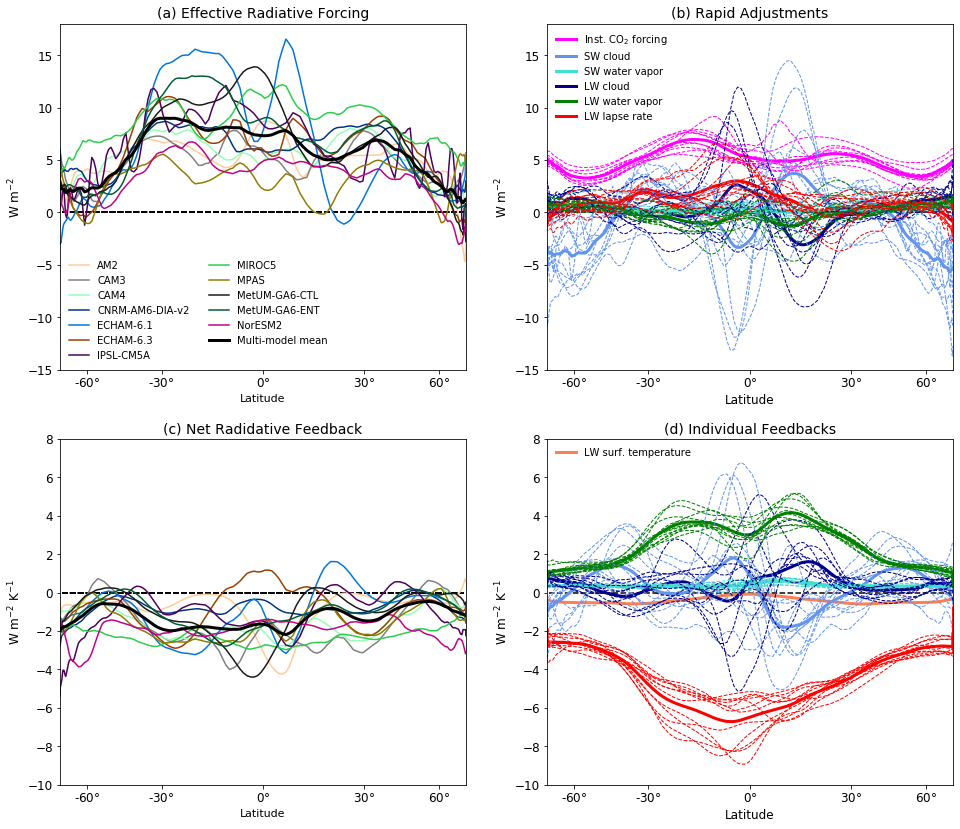

In [30]:
#Make the figure
plt.figure(figsize=(16,14))

#Effective Forcing
ax = plt.subplot(2,2,1)
for model in models_12:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['forcing'].sel(model=model), color=voigtColors[model])
    plt.hlines(0, -.99, .99, linestyles='dashed')
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['forcing'].mean(dim='model'), 'k', linewidth=3)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.xlabel('Latitude', fontsize=11)
plt.title('(a) Effective Radiative Forcing', fontsize=14)
ax.legend(legend_12, loc = 'lower left', frameon=False, ncol=2)
plt.axis([-1, 1, -15, 18])

#Net Feedback
ax = plt.subplot(2,2,3)
for model in models_12:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['feedback'].sel(model=model), color=voigtColors[model])
    plt.hlines(0, -.99, .99, linestyles='dashed')
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_total['feedback'].mean(dim='model'), 'k', linewidth=3)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$ K$^{-1}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.xlabel('Latitude', fontsize=11)
plt.title('(c) Net Radidative Feedback', fontsize=14)
plt.axis([-1, 1, -10, 8])

#Individual Rapid Adjustments and feedbacks
lat = ds_total.lat
sinlat = np.sin(lat*np.pi/180.)

#Individual Rapid Adjustments
#Set up panel
ax = plt.subplot(2,2,2)
plt.hlines(0, -.99, .99, linestyles='dashed')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.title('(b) Rapid Adjustments', fontsize=14)
#Means
plt.plot(sinlat, f_inst.mean(dim='model'), color='magenta', linewidth=3)
plt.plot(sinlat, ds_APRP['adj_cloud'].mean(dim='model'), 'cornflowerblue', linewidth=3)
plt.plot(sinlat, ds_APRP['adj_noncloud'].mean(dim='model'), 'turquoise', linewidth=3)
plt.plot(sinlat, ds_dLWCRE_co['adj'].mean(dim='model'), 'darkblue', linewidth=3)
plt.plot(sinlat, -ds_kernel_wv['adj'].sel(model=models_noCNRM).mean(dim='model'), 'green', linewidth=3)
plt.plot(sinlat, -ds_kernel_ta['adj'].mean(dim='model'), 'red', linewidth=3)
#Spreads (individual models)
for model in f_inst.model.data:
    plt.plot(sinlat, f_inst.sel(model=model), 'magenta', linewidth=1, linestyle='dashed')
for model in ds_APRP.model.data:
    plt.plot(sinlat, ds_APRP['adj_cloud'].sel(model=model), 'cornflowerblue', linewidth=1, linestyle='dashed')
    plt.plot(sinlat, ds_APRP['adj_noncloud'].sel(model=model), 'turquoise', linewidth=1, linestyle='dashed')
for model in ds_dLWCRE_co.model.data:
    plt.plot(sinlat, ds_dLWCRE_co['adj'].sel(model=model), 'darkblue', linewidth=1, linestyle='dashed')
for model in ds_kernel_wv.model.data:
    plt.plot(sinlat, -ds_kernel_wv['adj'].sel(model=model), 'green', linewidth=1, linestyle='dashed')
for model in ds_kernel_ta.model.data:
    plt.plot(sinlat, -ds_kernel_ta['adj'].sel(model=model), 'red', linewidth=1, linestyle='dashed')
#finish panel stuff
ax.legend(legend_adjustments, loc = 'upper left', frameon=False)
plt.axis([-1, 1, -15, 18])


#Individual Feedbacks
#Set up panel
ax = plt.subplot(2,2,4)
plt.hlines(0, -.99, .99, linestyles='dashed')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('W m$^{-2}$ K$^{-1}$', fontsize=12)
ax.set_xticks([-.866, -.5, 0, .5, .866])
ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
ax.tick_params(labelsize=12)
plt.title('(d) Individual Feedbacks', fontsize=14)
#Means
plt.plot(sinlat, -ds_kernel_ts['fb'].mean(dim='model'), 'coral', linewidth=3)
plt.plot(sinlat, ds_APRP['fb_cloud'].mean(dim='model'), 'cornflowerblue', linewidth=3)
plt.plot(sinlat, ds_APRP['fb_noncloud'].mean(dim='model'), 'turquoise', linewidth=3)
plt.plot(sinlat, ds_dLWCRE_co['fb'].mean(dim='model'), 'darkblue', linewidth=3)
plt.plot(sinlat, -ds_kernel_wv['fb'].sel(model=models_noCNRM).mean(dim='model'), 'green', linewidth=3)
plt.plot(sinlat, -ds_kernel_ta['fb'].mean(dim='model'), 'red', linewidth=3)
#spreads
for model in ds_APRP.model.data:
    plt.plot(sinlat, ds_APRP['fb_cloud'].sel(model=model), 'cornflowerblue', linewidth=1, linestyle='dashed')
    plt.plot(sinlat, ds_APRP['fb_noncloud'].sel(model=model), 'turquoise', linewidth=1, linestyle='dashed')
for model in ds_dLWCRE_co.model.data:
    plt.plot(sinlat, ds_dLWCRE_co['fb'].sel(model=model), 'darkblue', linewidth=1, linestyle='dashed')
for model in ds_kernel_wv.model.data:
    plt.plot(sinlat, -ds_kernel_wv['fb'].sel(model=model), 'green', linewidth=1, linestyle='dashed')
for model in ds_kernel_ta.model.data:
    plt.plot(sinlat, -ds_kernel_ta['fb'].sel(model=model), 'red', linewidth=1, linestyle='dashed')
ax.legend(['LW surf. temperature'], loc = 'upper left', frameon=False)
plt.axis([-1, 1, -10, 8])


plt.savefig('plots/Figure2_indiv.png')
plt.savefig('plots/Figure2_indiv.pdf')


In [ ]:
#Very busy plot but, I believe, still readable. 
#Still, supplement figure showing all rapid adj. and feedbacks for each model
#is better to put in the supplement because people can see which model is which.

In [ ]:
#####   FIGURE S2   #####

In [31]:
def setuppanel_zonalmean(ax, title, ylabel = '', ylims='default', equator=False, fontsize=12):
    plt.hlines(0, -1, 1, linestyles='dashed') #zero line
    ax.set_xticks([-.866, -.5, 0, .5, .866])
    ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
    ax.tick_params(labelsize=12)
    plt.xlabel('Latitude', fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    ax.set_xlim([-1,1])
    if not ylims=='default':
        ax.set_ylim(ylims)
    if equator:
        plt.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', linewidth=0.5) 

/usr/local/python/anaconda3/envs/pangeo-latest/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


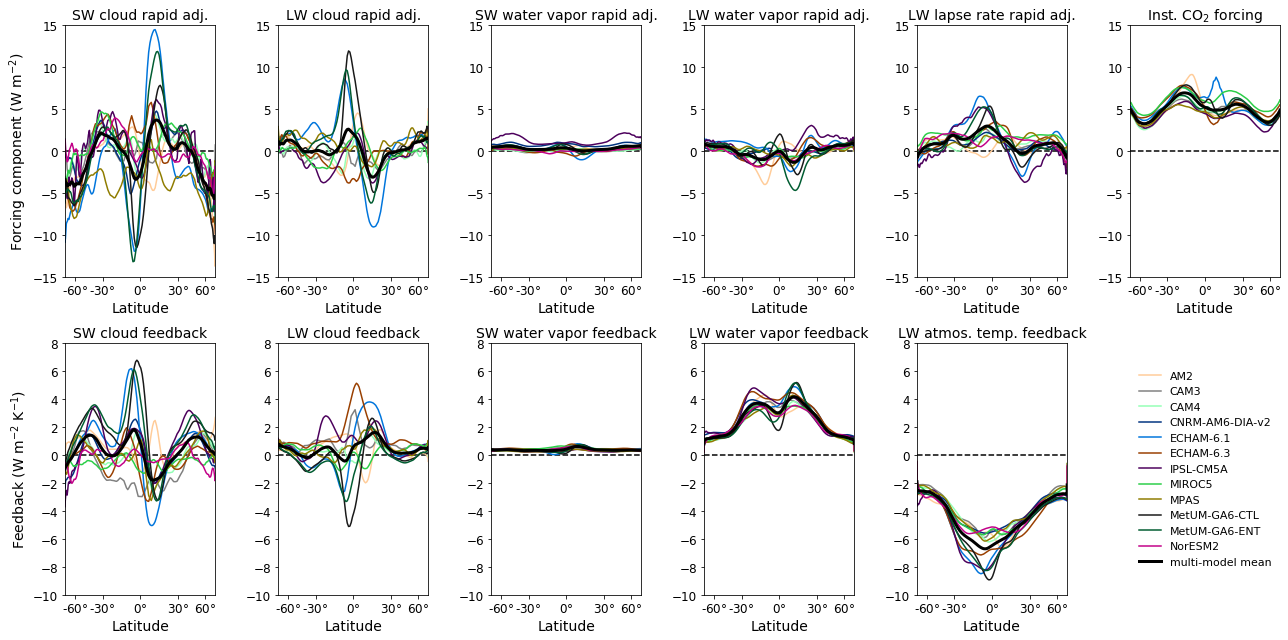

In [41]:
plt.figure(figsize=(18,9))

ax = plt.subplot(2,6,1)
setuppanel_zonalmean(ax, 'SW cloud rapid adj.', ylims=[-15,15], fontsize=14)
for model in ds_APRP.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['adj_cloud'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['adj_cloud'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('Forcing component (W m$^{-2}$)')

ax = plt.subplot(2,6,2)
setuppanel_zonalmean(ax, 'LW cloud rapid adj.', ylims=[-15,15], fontsize=14)
for model in ds_dLWCRE_co.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_dLWCRE_co['adj'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_dLWCRE_co['adj'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,3)
setuppanel_zonalmean(ax, 'SW water vapor rapid adj.', ylims=[-15,15], fontsize=14)
for model in ds_APRP.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['adj_noncloud'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['adj_noncloud'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,4)
setuppanel_zonalmean(ax, 'LW water vapor rapid adj.', ylims=[-15,15], fontsize=14)
for model in ds_kernel_wv.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_wv['adj'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_wv['adj'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,5)
setuppanel_zonalmean(ax, 'LW lapse rate rapid adj.', ylims=[-15,15], fontsize=14)
for model in ds_kernel_ta.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_ta['adj'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_ta['adj'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,6)
setuppanel_zonalmean(ax, 'Inst. CO$_2$ forcing', ylims=[-15,15], fontsize=14)
for model in f_inst.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), f_inst.sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), f_inst.mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')


ax = plt.subplot(2,6,7)
setuppanel_zonalmean(ax, 'SW cloud feedback', ylims=[-10,8], fontsize=14)
for model in ds_APRP.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['fb_cloud'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['fb_cloud'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('Feedback (W m$^{-2}$ K$^{-1}$)')

ax = plt.subplot(2,6,8)
setuppanel_zonalmean(ax, 'LW cloud feedback', ylims=[-10,8], fontsize=14)
for model in ds_dLWCRE_co.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_dLWCRE_co['fb'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_dLWCRE_co['fb'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,9)
setuppanel_zonalmean(ax, 'SW water vapor feedback', ylims=[-10,8], fontsize=14)
for model in ds_APRP.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['fb_noncloud'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), ds_APRP['fb_noncloud'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,10)
setuppanel_zonalmean(ax, 'LW water vapor feedback', ylims=[-10,8], fontsize=14)
for model in ds_kernel_wv.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_wv['fb'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_wv['fb'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

ax = plt.subplot(2,6,11)
setuppanel_zonalmean(ax, 'LW atmos. temp. feedback', ylims=[-10,8], fontsize=14)
for model in ds_kernel_ta.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_ta['fb'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_ta['fb'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')

#Legend in 12th panel
ax = plt.subplot(2,6,12)
setuppanel_zonalmean(ax, '', ylims=[1000, 1012], fontsize=14)
for model in ds_kernel_ta.model.data:
    plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_ta['fb'].sel(model=model), color=voigtColors[model])
plt.plot(np.sin(ds_total.lat*np.pi/180.), -ds_kernel_ta['fb'].mean(dim='model'), 'k', linewidth=3)
plt.ylabel('')
legendText = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1', 'ECHAM-6.3',
       'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT', 'NorESM2', 'multi-model mean']
plt.legend(legendText, loc='center', frameon=False, ncol=1, fontsize=11)
plt.xlabel('')
plt.axis('off')


plt.tight_layout()

plt.savefig('plots/adj_fb_indiv_models.png')
plt.savefig('plots/adj_fb_indiv_models.pdf')